<a href="https://colab.research.google.com/github/Hsuhuiying/STAT/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
#我的雲端硬碟
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import time
import math
import tensorflow as tf

from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#設定訓練常數
# 訓練樣本數比例
SPLIT_RATIO = 0.8
# 感知器記憶長度
LOOK_BACK = 200
#設定排序隨機碼，之後能夠重現訓練過程
np.random.seed(5)

In [ ]:
#載入資料  #NVDA.csv：輝達
import pandas as pd
nvda_prices = pd.read_csv('/content/drive/MyDrive/NVDA.csv',delimiter=',')
labels = nvda_prices['close'].values #收盤價(close)作為目標
dataset = labels.reshape(-1, 1)
print(f'資料集 {dataset[:10]} 長度 {len(dataset)}') #檢查數據內容與長度

#index_col=None:指定不要將任何欄位設為索引
#delimiter=',' 明確定義資料分隔符號為逗號（這是 CSV 的預設值）
#.values：將這個欄位的內容轉換為 NumPy 陣列
#reshape(-1,1)：將原本的一維陣列（長度1941）轉換為二維陣列,
#形狀為(1941,1)，其中每行是一個收盤價值

資料集 [[204.16  ]
 [200.71  ]
 [205.3801]
 [207.71  ]
 [205.82  ]
 [206.8798]
 [206.5102]
 [202.55  ]
 [201.32  ]
 [200.865 ]] 長度 1941


In [ ]:
#標準化資料
from sklearn.preprocessing import MinMaxScaler#數據標準化的工具
Scaler = MinMaxScaler(feature_range=(0, 1))
dataset = Scaler.fit_transform(dataset)
split_size = int(len(dataset) * SPLIT_RATIO) #SPLIT_RATIO:訓練集所佔比例
test_size = len(dataset) - split_size

train_dataset = dataset[0:split_size, :]
test_dataset = dataset[split_size:len(dataset), :]
print(f'訓練資料集 {train_dataset[:10]} 長度 {len(train_dataset)}')
print(f'測試資料集 {test_dataset[:10]} 長度 {len(test_dataset)}')

訓練資料集 [[0.05908655]
 [0.00399233]
 [0.07857074]
 [0.11577771]
 [0.08559566]
 [0.10251996]
 [0.09661769]
 [0.03337592]
 [0.01373363]
 [0.00646758]] 長度 1552
測試資料集 [[0.90673906]
 [0.79591185]
 [0.79525391]
 [0.80804855]
 [0.83082082]
 [0.82155222]
 [0.84374162]
 [0.85683488]
 [0.85157298]
 [0.84701373]] 長度 389


In [ ]:
#分訓練集和測試集
def buildDataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
train_x, train_y = buildDataset(train_dataset, LOOK_BACK)
test_x, test_y = buildDataset(test_dataset, LOOK_BACK)

#look_back=1：使用過去1個時間點的數據來預測下一個數據點

#重塑訓練集:因為LSTM和RNN模型的輸入格式要求三維數據，形狀為(樣本數,時間跨度,特徵數)
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
#樣本數：輸入數據的總樣本量 #時間跨度：look_back
#特徵數：每個時間點的特徵數量（對於單一特徵，特徵數為1）

In [ ]:
#建立 LSTM 模型
#使用 adam 優化器、單層250個神經元、隨機排除 10% 權重
Model = Sequential()
Model.add(LSTM(250, input_shape=(1, LOOK_BACK)))
Model.add(Dropout(0.1))
Model.add(Dense(1))
Model.compile(loss='mse', optimizer='adam')
Model.fit(train_x, train_y, epochs=1000, batch_size=240, verbose=0)

#Model = Sequential():模型是按層次結構逐層建立，前一層的輸出自動成為下一層的輸入
#Model.add(Dropout(0.1)):Dropout是一種正則化技術，用於減少過擬合的風險
 #(0.1 表示在每次訓練中隨機丟棄10%的神經元權重，從而提升模型的泛化能力)
#epochs:訓練的迭代次數
#batch_size:每次訓練所使用的數據量大小
#verbose:設定訓練過程的輸出模式

In [ ]:
#預測資料
train_predict = Model.predict(train_x)
test_predict = Model.predict(test_x)

#將預測結果從標準化的形式反轉回原始數值範圍，以便進行結果比較
train_predict = Scaler.inverse_transform(train_predict)
train_y = Scaler.inverse_transform([train_y])
test_predict = Scaler.inverse_transform(test_predict)
test_y = Scaler.inverse_transform([test_y])

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [ ]:
#計算預測誤差 RMSE
train_score = math.sqrt(mean_squared_error(train_y[0], train_predict[:,0]))
print(f'訓練誤差分數(RMSE):{np.round(train_score, 3)}')

test_score = math.sqrt(mean_squared_error(test_y[0], test_predict[:,0]))
print(f'測試誤差分數(RMSE):{np.round(test_score, 3)}')

訓練誤差分數(RMSE)：0.988
測試誤差分數(RMSE)：0.741


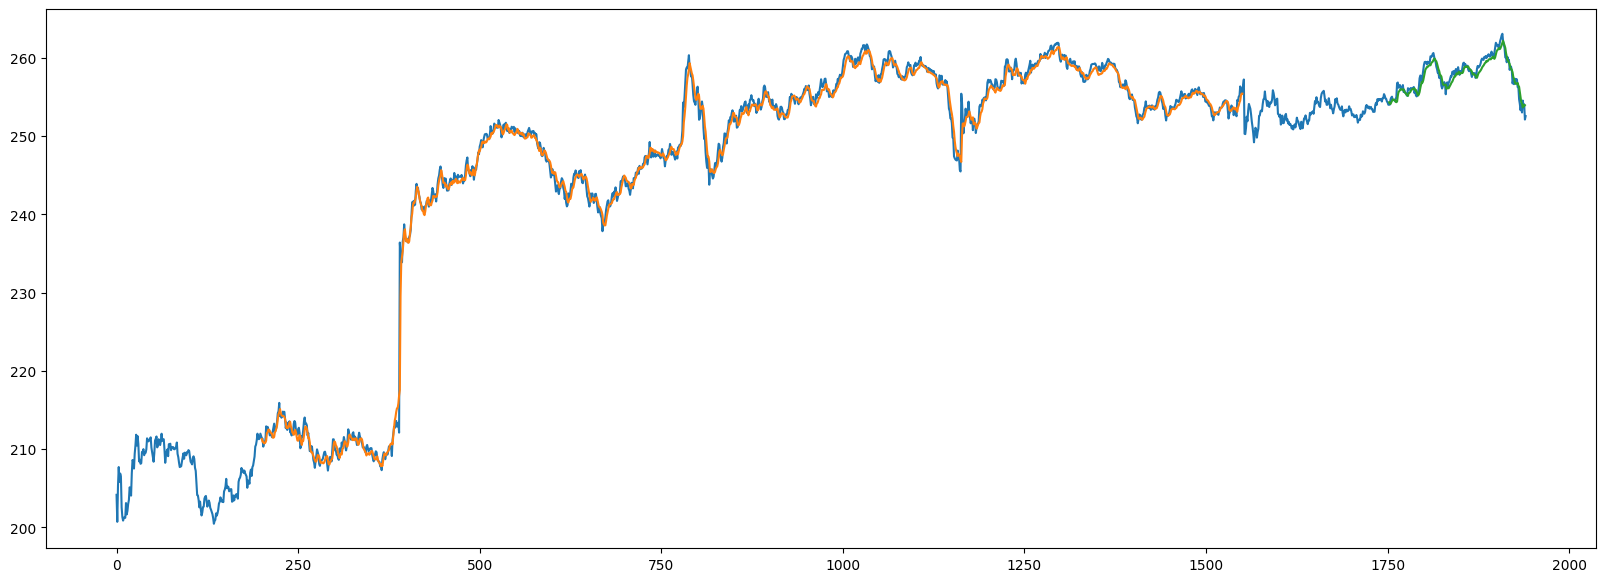

In [ ]:
#畫圖
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[LOOK_BACK:len(train_predict) + LOOK_BACK, :] = train_predict
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (LOOK_BACK * 2) + 1:len(dataset)-1, :] = test_predict

plt.figure(figsize=(20, 7))
plt.plot(Scaler.inverse_transform(dataset))

plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [ ]:
#結果
test_prices = Scaler.inverse_transform(dataset[len(dataset) - len(test_predict):])
result = pd.DataFrame(
    data={
        "測試價格": np.around(list(test_prices.reshape(-1)), decimals=2),
        "預測價格": np.around(list(test_predict.reshape(-1)), decimals=2)
    }
)
print(result)

       測試價格        預測價格
0    254.02  254.330002
1    254.68  254.169998
2    254.94  254.110001
3    255.04  254.330002
4    254.60  254.500000
..      ...         ...
183  254.54  254.160004
184  253.91  253.669998
185  254.05  253.949997
186  252.12  253.830002
187  252.56  253.949997

[188 rows x 2 columns]


此範例參考以下網站:

https://www.kaggle.com/code/psheon/08-lstm-for-prediction/notebook
